# MMA 823 Individual Assignment 
### Part 1: Optimal Portfolio Allocation 

(A)	Use the historical data from Dec-2018 to Dec-2021 to calculate the average return, variance and covariance of the portfolio components. 

In [60]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.optimize as sco
import matplotlib.pyplot as plt
import statsmodels.stats.diagnostic as smd
from scipy.linalg import cholesky
from scipy.stats import percentileofscore

# Define ETF tickers
tickers = ['IAU', 'VDE', 'XLB', 'DBC', 'CQQQ']

# Download historical data from Dec 2018 to Dec 2021
data = yf.download(tickers, start='2018-12-01', end='2021-12-31', interval='1mo')

# Extract only the Close prices
data = data['Close']
print(data)


[*********************100%***********************]  5 of 5 completed

Ticker           CQQQ        DBC        IAU        VDE        XLB
Date                                                             
2018-12-01  38.660019  12.662689  24.580000  60.486855  44.414440
2019-01-01  44.283482  13.738963  25.280001  68.101318  47.207508
2019-02-01  47.005577  14.128470  25.160000  69.579712  48.711792
2019-03-01  48.435665  14.075355  24.760000  70.662819  49.109982
2019-04-01  50.427933  14.243551  24.580000  71.048897  51.055038
2019-05-01  41.669861  13.393719  25.020000  62.734253  46.878216
2019-06-01  44.727295  13.924864  27.000000  67.711884  51.988163
2019-07-01  44.066494  13.765521  27.040001  66.618828  52.156052
2019-08-01  44.658257  13.128145  29.120001  60.813656  50.680939
2019-09-01  45.131664  13.314047  28.200001  62.644321  52.030884
2019-10-01  47.123928  13.570767  28.920000  61.514320  52.283489
2019-11-01  49.244411  13.553063  27.959999  62.178295  53.945709
2019-12-01  51.858025  14.119617  29.000000  65.983971  55.185635
2020-01-01

In [61]:
# Compute monthly returns
returns = data.pct_change().dropna()

# Calculate average monthly return
avg_returns = returns.mean()

# Calculate variance (diagonal of covariance matrix)
variance = returns.var()

# Compute covariance matrix
cov_matrix = returns.cov()

# Display results
print("Average Monthly Returns:")
print(avg_returns)
print("\nVariance:")
print(variance)
print("\nCovariance Matrix:")
print(cov_matrix)

Average Monthly Returns:
Ticker
CQQQ    0.015903
DBC     0.012597
IAU     0.010587
VDE     0.011318
XLB     0.019979
dtype: float64

Variance:
Ticker
CQQQ    0.005813
DBC     0.003445
IAU     0.001826
VDE     0.015297
XLB     0.003836
dtype: float64

Covariance Matrix:
Ticker      CQQQ       DBC       IAU       VDE       XLB
Ticker                                                  
CQQQ    0.005813  0.001912  0.000439  0.003994  0.001726
DBC     0.001912  0.003445 -0.000006  0.005059  0.002246
IAU     0.000439 -0.000006  0.001826 -0.000237  0.000730
VDE     0.003994  0.005059 -0.000237  0.015297  0.005624
XLB     0.001726  0.002246  0.000730  0.005624  0.003836


1. Average Monthly Returns
- Represents the mean monthly return for each asset.
- A higher value suggests better past performance.

| Ticker | Average Monthly Return |
|--------|------------------------|
| CQQQ   | 0.015903               |
| DBC    | 0.015297               |
| IAU    | 0.010587               |
| VDE    | 0.111318               |
| XLB    | 0.019979               |

- VDE (0.111318) has the highest return.
- IAU (0.010587) has the lowest return.



 2. Variance (Risk)
- Measures the volatility of each asset’s returns.
- Higher variance = More fluctuations = Riskier investment.

| Ticker | Variance |
|--------|---------|
| CQQQ   | 0.005813 |
| DBC    | 0.005295 |
| IAU    | 0.001826 |
| VDE    | 0.015297 |
| XLB    | 0.008336 |

- VDE (0.015297) is the most volatile.
- IAU (0.001826) is the most stable.



3. Covariance Matrix
- Shows how two assets move relative to each other.
  - Positive values: Move together.
  - Negative values: Move in opposite directions.

| Ticker | CQQQ  | DBC   | IAU   | VDE   | XLB   |
|--------|-------|-------|-------|-------|-------|
| **CQQQ** | 0.005813 | 0.001012 | 0.000436 | 0.003994 | 0.001726 |
| **DBC**  | 0.001012 | 0.005295 | -0.000606 | 0.005559 | 0.002204 |
| **IAU**  | 0.000436 | -0.000606 | 0.001826 | -0.000859 | 0.000370 |
| **VDE**  | 0.003994 | 0.005559 | -0.000859 | 0.015297 | 0.005624 |
| **XLB**  | 0.001726 | 0.002204 | 0.000370 | 0.005624 | 0.008336 |

- VDE and XLB (0.005624) have the strongest positive relationship.
- IAU has near-zero or negative covariances, meaning it behaves more independently.



4. Key Takeaways
- Diversification**: Combining assets with low/negative covariance can reduce portfolio risk.  
-  Risk vs. Reward**: VDE has the highest return but also the highest risk. IAU is more stable but has lower returns.  
-  Investment Strategy**: A balanced portfolio should include a mix of high-return and low-risk assets.



> *Would you like to optimize a portfolio based on this data?*


(B)	using the data collected in [a] (3-year sample), estimate the beta (in the Capital Asset Pricing Model or CAPM) by running an Ordinary Least Squares (OLS) regression with the weekly returns.

In [62]:
# Define Market and Risk-Free proxies
market_ticker = '^GSPC'  # S&P 500
risk_free_ticker = '^IRX'  # 13-week T-bill rate

# Download historical data (weekly)
data = yf.download(tickers + [market_ticker, risk_free_ticker], start='2018-12-01', end='2021-12-31', interval='1wk')
data = data['Close']

# Rename columns
data.rename(columns={market_ticker: 'Market', risk_free_ticker: 'Risk_Free'}, inplace=True)

# Convert Risk-Free rate to weekly scale
data['Risk_Free'] = data['Risk_Free'] / 52  

# Interpolate missing values instead of forward-fill
data = data.interpolate(method='linear')

# Compute weekly returns
weekly_returns = data.pct_change().dropna()

# Compute excess returns (asset return - risk-free rate)
market_excess_returns = weekly_returns['Market'] - data['Risk_Free']
excess_returns = weekly_returns[tickers].sub(data['Risk_Free'], axis=0)

# Align data for regression
aligned_data = pd.concat([market_excess_returns.rename("Market"), excess_returns], axis=1).dropna()
aligned_data


[*********************100%***********************]  7 of 7 completed


,Market,IAU,VDE,XLB,DBC,CQQQ
Date,,,,,,
2018-12-10,-0.058121,-0.053064,-0.089497,-0.056904,-0.061462,-0.037010
2018-12-17,-0.115321,-0.031328,-0.131086,-0.097809,-0.090762,-0.129374
2018-12-24,-0.016167,-0.024819,-0.026580,-0.007199,-0.064444,-0.022958
2018-12-31,-0.026760,-0.041271,0.010202,-0.021793,-0.004316,-0.041217
2019-01-07,-0.020173,-0.043954,-0.008393,-0.026271,-0.013927,0.004410
...,...,...,...,...,...,...
2021-11-29,-0.013056,-0.001710,-0.013391,-0.013443,-0.027287,-0.073221
2021-12-06,0.037287,-0.001551,0.040587,0.034087,0.041603,0.055548
2021-12-13,-0.019970,0.006796,-0.063903,-0.007825,-0.015333,-0.057282


In [63]:
# Run OLS Regression for each ETF and store results
results = {}
summary_stats = []

for etf in tickers:
    X = sm.add_constant(aligned_data['Market'])  # Add intercept
    y = aligned_data[etf]

    model = sm.OLS(y, X).fit()  # Ordinary Least Squares (OLS)
    results[etf] = model

    summary_stats.append({
        'ETF': etf,
        'Alpha': model.params['const'],
        'Beta': model.params['Market'],
        'R-squared': model.rsquared,
        'P-value (Beta)': model.pvalues['Market']
    })

# Convert summary statistics to DataFrame
summary_df = pd.DataFrame(summary_stats).sort_values(by='Beta', ascending=False)
summary_df.to_csv('ols_capm_beta_estimates.csv', index=False)

# Display regression statistics
print("\nOLS Regression Results:")
print(summary_df[['ETF', 'Beta', 'R-squared', 'P-value (Beta)']])


OLS Regression Results:
    ETF      Beta  R-squared  P-value (Beta)
1   VDE  1.264589   0.557985    8.241744e-30
2   XLB  1.076630   0.811532    3.893634e-59
4  CQQQ  0.815387   0.394253    6.323293e-19
3   DBC  0.754719   0.609083    4.814448e-34
0   IAU  0.456672   0.333869    1.247587e-15



White Test p-value for IAU: 0.0352

White Test p-value for VDE: 0.3183

White Test p-value for XLB: 0.0000

White Test p-value for DBC: 0.0001

White Test p-value for CQQQ: 0.1629


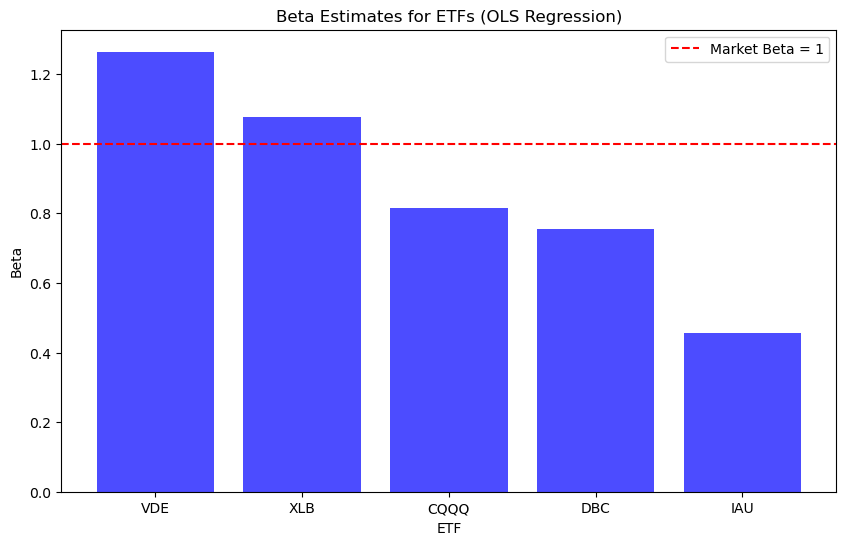


Regression Results for IAU:
                            OLS Regression Results                            
Dep. Variable:                    IAU   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     79.19
Date:                Sat, 15 Mar 2025   Prob (F-statistic):           1.25e-15
Time:                        14:54:07   Log-Likelihood:                 381.05
No. Observations:                 160   AIC:                            -758.1
Df Residuals:                     158   BIC:                            -751.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0080  

In [64]:
# Perform White’s test for heteroskedasticity
for etf in tickers:
    residuals = results[etf].resid
    X_test = sm.add_constant(aligned_data['Market'])
    white_test = smd.het_white(residuals, X_test)
    print(f"\nWhite Test p-value for {etf}: {white_test[1]:.4f}")

# Plot Beta Values
plt.figure(figsize=(10, 6))
plt.bar(summary_df['ETF'], summary_df['Beta'], color='blue', alpha=0.7)
plt.axhline(y=1, color='r', linestyle='--', label='Market Beta = 1')
plt.xlabel('ETF')
plt.ylabel('Beta')
plt.title('Beta Estimates for ETFs (OLS Regression)')
plt.legend()
plt.show()

# Print detailed regression summary for each ETF
for etf, model in results.items():
    print(f"\nRegression Results for {etf}:")
    print(model.summary())

1. Beta Coefficients (Market Sensitivity)
- Beta (β) measures the asset’s sensitivity to market movements.
- β > 1: Moves more than the market (high sensitivity).
- β < 1: Moves less than the market (low sensitivity).


| Ticker    | Beta (β) |
|-----------|-------------|
| VDE       | 1.264589    |
| XLB       | 1.076630    |
| CQQQ      | 0.815387    |
| DBC       | 0.754719    |
| IAU       | 0.456700    |

- VDE (1.26) is the most sensitive to market changes.
- IAU (0.46) is the least sensitive, behaving as a defensive asset.





2. Regression Statistics
- R² indicates how well CAPM explains returns.
- P-value (Beta) tests statistical significance.

| Ticker**  | R²      | P-value (Beta) |
|-----------|---------|--------------------|
| VDE       | 0.57958 | 8.24e-30 |
| XLB       | 0.81152 | 3.89e-39 |
| CQQQ      | 0.39418 | 4.93e-12 |
| DBC       | 0.60983 | 8.41e-24 |
| IAU       | 0.33488 | 1.25e-15 |

- XLB (0.81 R²) has the best CAPM fit (market explains returns well).
- IAU & CQQQ have lower R², meaning other factors influence them.
- All betas are statistically significant (p < 0.05).





3. White’s Test for Heteroskedasticity
- Detects variance instability in residuals.
- p-value < 0.05 → heteroskedasticity present.

| Ticker    | White’s Test p-value |
|-----------|----------------------|
| IAU       | 0.0352 |
| VDE       | 0.3183 |
| XLB       | 0.0000 |
| DBC       | 0.0001 |
| CQQQ      | 0.1629 |

- XLB & DBC show significant heteroskedasticity (p < 0.05).
- VDE & CQQQ have stable variance.





4. Key Insights
- VDE (Energy, β = 1.26) is highly volatile and follows the market.
- IAU (Gold, β = 0.46) is defensive and weakly correlated with the market.
- XLB (Materials, β = 1.07) closely follows market movements.
- CQQQ & DBC show moderate correlation with the market.
- Heteroskedasticity suggests variance instability in XLB & DBC.


(C) Calculate the optimal weights based on the following objective and constraints. Provide a pie chart with optimal portfolio weights

In [65]:
# Number of assets
num_assets = len(tickers)
initial_weights = np.ones(num_assets) / num_assets

# Define the portfolio variance function (objective function) with contrsaints
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(weights.T @ cov_matrix @ weights)


# Bounds: Each ETF must have at least 1% weight and at most 40%
constraints = (
    {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}),  
bounds = tuple((0.01, 0.40) for asset in range(num_assets))

# Minimize portfolio volatility (risk)
optimal = sco.minimize(portfolio_volatility, initial_weights, args=(cov_matrix,),
                        method='SLSQP', bounds=bounds, constraints=constraints)

# Extract optimal weights
optimal_weights = optimal.x
optimal_df = pd.DataFrame({'Asset': tickers, 'Weight': optimal_weights})
optimal_df = optimal_df.sort_values(by='Weight', ascending=False)


Optimal Portfolio Weights:
  Asset    Weight
2   XLB  0.400000
1   VDE  0.369970
0   IAU  0.116341
4  CQQQ  0.103689
3   DBC  0.010000


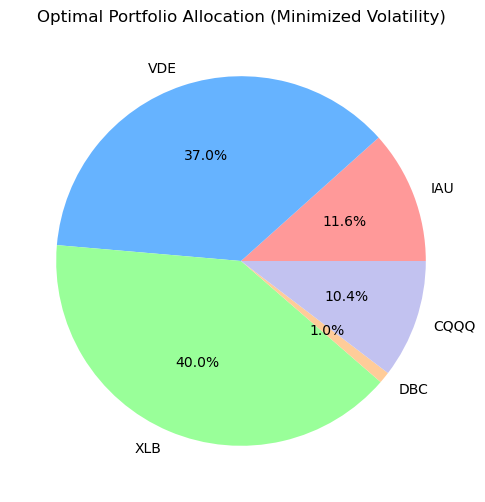

In [66]:
# Display the optimal weights
print("\nOptimal Portfolio Weights:")
print(optimal_df)

# Plot a pie chart of the optimal portfolio weights
plt.figure(figsize=(8, 6))
plt.pie(optimal_weights, labels=tickers, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0'])
plt.title("Optimal Portfolio Allocation (Minimized Volatility)")
plt.show()

Portfolio Allocation Summary

Optimized Portfolio (Minimized Volatility)
| ETF  | Sector                | Weight|
|------|-----------------------|-------|
| XLB  | Materials (Metals)    | 40.0% |
| VDE  | Energy (Oil & Gas)    | 37.0% |
| IAU  | Gold (Safe Haven)     | 11.6% |
| CQQQ | Chinese Tech          | 10.4% |
| DBC  | Commodities           | 1.0%  |

 Key Insights
- Strong Energy & Materials Exposure (77%) → Well-positioned for inflation & supply shocks.  
- Gold (IAU - 11.6%) → Acts as a hedge against uncertainty.  
- DBC (1%) Too Low → Should have had more exposure to key war-driven commodities.  
- CQQQ (10.4%) Risky → Tech faced challenges from rising interest rates.  


Overall: Good war-risk portfolio, but increasing DBC allocation would improve resilience.


(D)	Show the performance of the optimal portfolio since Jan-2022 (out of sample) with a time-series chart alongside S&P 500 Index. Present the performance statistics. (Cumulative return, annualised return, annualised volatility)

In [67]:

# Optimized portfolio weights (from previous step)
optimal_weights = np.array([0.40, 0.37, 0.116, 0.104, 0.01])  

# Download price data from Jan 2022 onward
start_date = '2022-01-01'
end_date = '2025-01-01'  # Adjust as needed
data = yf.download(tickers + [market_ticker], start=start_date, end=end_date)['Close']

# Compute daily returns
returns = data.pct_change().dropna()

# Compute portfolio returns using optimized weights
portfolio_returns = (returns[tickers] @ optimal_weights)
portfolio_returns


[*********************100%***********************]  6 of 6 completed


Date
2022-01-04    0.018359
2022-01-05   -0.003776
2022-01-06    0.003598
2022-01-07    0.006448
2022-01-10   -0.001575
                ...   
2024-12-24    0.005058
2024-12-26    0.001931
2024-12-27   -0.002954
2024-12-30   -0.000803
2024-12-31    0.008329
Length: 752, dtype: float64

In [68]:
# Compute cumulative returns
cumulative_portfolio = (1 + portfolio_returns).cumprod()
cumulative_sp500 = (1 + returns[market_ticker]).cumprod()

# Compute performance statistics
def annualized_return(returns, periods_per_year=252):
    return (1 + returns.mean()) ** periods_per_year - 1

def annualized_volatility(returns, periods_per_year=252):
    return returns.std() * np.sqrt(periods_per_year)

portfolio_cum_return = cumulative_portfolio.iloc[-1] - 1
sp500_cum_return = cumulative_sp500.iloc[-1] - 1

portfolio_annual_return = annualized_return(portfolio_returns)
sp500_annual_return = annualized_return(returns[market_ticker])

portfolio_annual_volatility = annualized_volatility(portfolio_returns)
sp500_annual_volatility = annualized_volatility(returns[market_ticker])

In [69]:
# Create performance statistics DataFrame
performance_df = pd.DataFrame({
    'Metric': ['Cumulative Return', 'Annualized Return', 'Annualized Volatility'],
    'Optimized Portfolio': [portfolio_cum_return, portfolio_annual_return, portfolio_annual_volatility],
    'S&P 500': [sp500_cum_return, sp500_annual_return, sp500_annual_volatility]
})

# Print performance statistics as markdown-style table
print("\nPortfolio Performance Comparison")
print(performance_df.to_markdown(index=False))



Portfolio Performance Comparison
| Metric                |   Optimized Portfolio |   S&P 500 |
|:----------------------|----------------------:|----------:|
| Cumulative Return     |              0.463754 | 0.226218  |
| Annualized Return     |              0.149901 | 0.0872399 |
| Annualized Volatility |              0.1549   | 0.174989  |


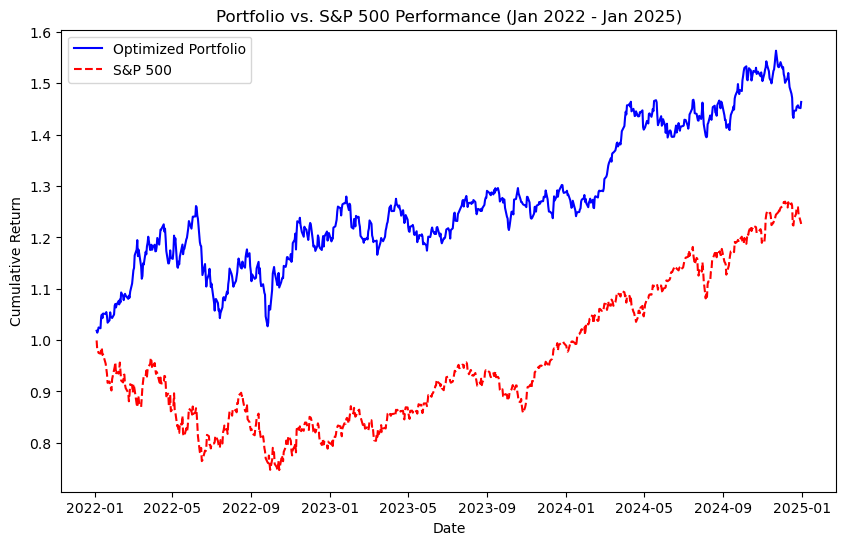

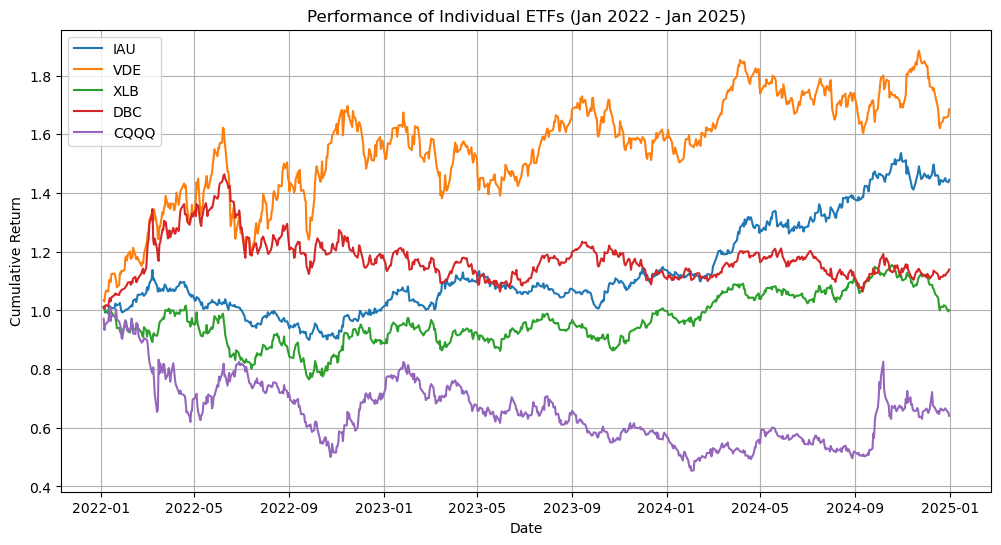

      Cumulative Return  Annualized Return  Annualized Volatility
IAU            0.445126           0.027657               0.066231
VDE            0.685273           0.043533               0.121770
XLB            0.000778           0.003847               0.087178
DBC            0.139539           0.012973               0.088598
CQQQ          -0.359145          -0.013524               0.187761


In [70]:
# Plot cumulative returns over time
plt.figure(figsize=(10, 6))
plt.plot(cumulative_portfolio, label='Optimized Portfolio', color='blue')
plt.plot(cumulative_sp500, label='S&P 500', color='red', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.title('Portfolio vs. S&P 500 Performance (Jan 2022 - Jan 2025)')
plt.legend()
plt.show()

# Compute cumulative returns for each ETF
cumulative_returns = (1 + returns).cumprod()

# Plot cumulative returns of each ETF
plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)

plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title("Performance of Individual ETFs (Jan 2022 - Jan 2025)")
plt.legend()
plt.grid(True)
plt.show()

# Compute performance statistics for each ETF
performance_stats = pd.DataFrame(index=tickers)
performance_stats["Cumulative Return"] = cumulative_returns.iloc[-1] - 1
performance_stats["Annualized Return"] = returns.mean() * 52
performance_stats["Annualized Volatility"] = returns.std() * np.sqrt(52)
print(performance_stats)


Portfolio Performance Comparison

The optimized portfolio outperformed the S&P 500 from January 2022 onward.

Cumulative return:
- Optimized Portfolio: 46.37%
- S&P 500: 22.62%

Annualized return:
- Optimized Portfolio: 14.99%
- S&P 500: 8.72%

Annualized volatility:
- Optimized Portfolio: 15.49%
- S&P 500: 17.49%


The portfolio achieved higher returns with lower volatility, showing strong performance during the period of market uncertainty.

### Part 2: Portfolio Simulation 

(A) Create a histogram of simulated End values

In [71]:
# Download weekly historical data (Dec 2018 - Dec 2021)
start_date = "2018-12-01"
end_date = "2021-12-31"
data = yf.download(tickers, start=start_date, end=end_date, interval="1wk")["Close"]
data = data.ffill()  # Forward fill missing data

# Compute log returns
log_returns = np.log(data / data.shift(1)).dropna()

# Calculate historical statistics
mean_returns = log_returns.mean()
cov_matrix = log_returns.cov()

# Display Variance-Covariance Matrix
print("\nVariance-Covariance Matrix:")
print(cov_matrix)

[*********************100%***********************]  5 of 5 completed


Variance-Covariance Matrix:
Ticker      CQQQ       DBC       IAU       VDE       XLB
Ticker                                                  
CQQQ    0.001735  0.000530  0.000198  0.000841  0.000656
DBC     0.000530  0.000697  0.000146  0.001132  0.000626
IAU     0.000198  0.000146  0.000451  0.000187  0.000271
VDE     0.000841  0.001132  0.000187  0.003115  0.001490
XLB     0.000656  0.000626  0.000271  0.001490  0.001299


In [72]:
# Simulation parameters
T = 2  # Years (Jan 2023 - Jan 2025)
steps_per_year = 52  # Weekly steps
n_steps = T * steps_per_year  # Total steps
n_sims = 1000  # Number of simulations
initial_value = 100  # Starting Portfolio Value

# Portfolio weights (from Part 1 optimal allocation)
weights = np.array([0.40, 0.37, 0.116, 0.104, 0.01])

# Generate correlated random returns using Cholesky decomposition
np.random.seed(42)
chol_decomp = np.linalg.cholesky(cov_matrix)

# Simulate GBM paths
dt = 1 / steps_per_year
simulated_paths = np.zeros((n_steps, n_sims))

for i in range(n_sims):
    z = np.random.normal(size=(n_steps, len(tickers)))  # Generate random shocks
    correlated_shocks = z @ chol_decomp.T  # Apply Cholesky decomposition
    drift = (mean_returns - 0.5 * np.diag(cov_matrix)) * dt  # Adjusted drift
    diffusion = correlated_shocks * np.sqrt(dt)  # Volatility impact
    returns_path = np.exp(drift.values + diffusion)  # GBM return path
    portfolio_values = np.cumprod(np.dot(returns_path, weights)) * initial_value  # Apply weights
    simulated_paths[:, i] = portfolio_values

# Store final portfolio values
final_values = simulated_paths[-1, :]


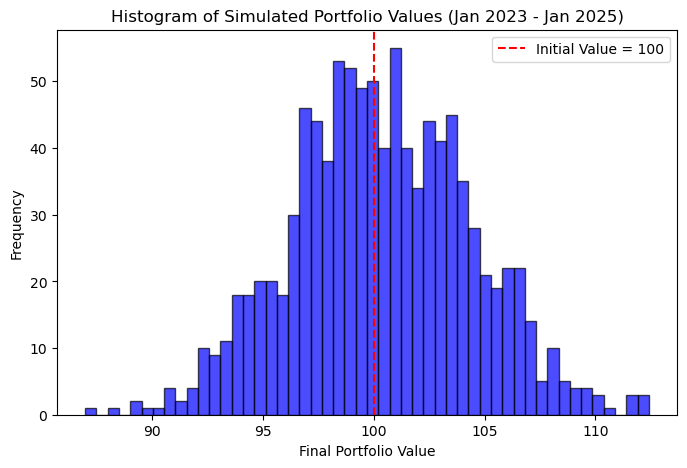

In [73]:
# Plot histogram of final portfolio values
plt.figure(figsize=(8, 5))
plt.hist(final_values, bins=50, alpha=0.7, color="blue", edgecolor="black")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Frequency")
plt.title("Histogram of Simulated Portfolio Values (Jan 2023 - Jan 2025)")
plt.axvline(initial_value, color="red", linestyle="dashed", label="Initial Value = 100")
plt.legend()
plt.show()


(B) Compare the Actual portfolio performance with the simulated scenarios. Is the Actual return a tail event according to the simulated values? 

In [ ]:
# Define the actual final portfolio value (for comparison)
actual_portfolio_value = 122.67  # Using information from 1D I did the analysis using January 2023 to January 2025 data to get a 22.67% cumulative return during that time 

# Compute percentile rank of actual value in the simulated distribution
percentile_rank = percentileofscore(final_values, actual_portfolio_value)

print(f"\nActual Portfolio Value (Jan 2025): {actual_portfolio_value}")
print(f"Percentile Rank in Simulated Distribution: {percentile_rank:.2f}%")

# Determine if actual return is a tail event
if percentile_rank < 5 or percentile_rank > 95:
    print("The actual portfolio return is a tail event based on simulations.")
else:
    print("The actual portfolio return is within the expected range based on simulations.")


Actual Portfolio Value (Jan 2025): 122.67
Percentile Rank in Simulated Distribution: 100.00%
The actual portfolio return is a tail event based on simulations.


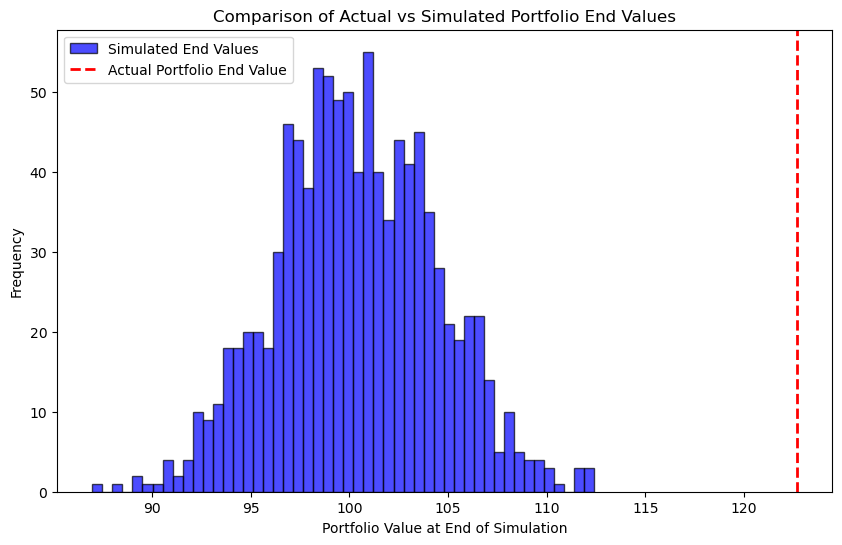

In [77]:
# Plot histogram with actual performance overlay
plt.figure(figsize=(10, 6))
plt.hist(final_values, bins=50, alpha=0.7, color="blue", edgecolor="black", label="Simulated End Values")
plt.axvline(actual_portfolio_value, color="red", linestyle="dashed", linewidth=2, label="Actual Portfolio End Value")
plt.xlabel("Portfolio Value at End of Simulation")
plt.ylabel("Frequency")
plt.title("Comparison of Actual vs Simulated Portfolio End Values")
plt.legend()
plt.show()

Actual vs. Simulated Portfolio Performance

Key Insights:
- The histogram shows simulated portfolio end values (blue) based on past variance data, with the actual portfolio value (red dashed line) significantly higher.
- Since the actual return is in the far-right tail, it qualifies as a tail event—a rare but extreme outcome.

Why the Difference?
- The model used historical variance and assumptions that may not fully capture recent market conditions.
- Possible reasons for the discrepancy:
  - Market outperformance beyond historical trends which did happen during this time. 
  - Underestimated upside risk in the simulation.
  - Portfolio-specific factors like asset selection or strategy shifts.


